# Projekt

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
from copy import deepcopy

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


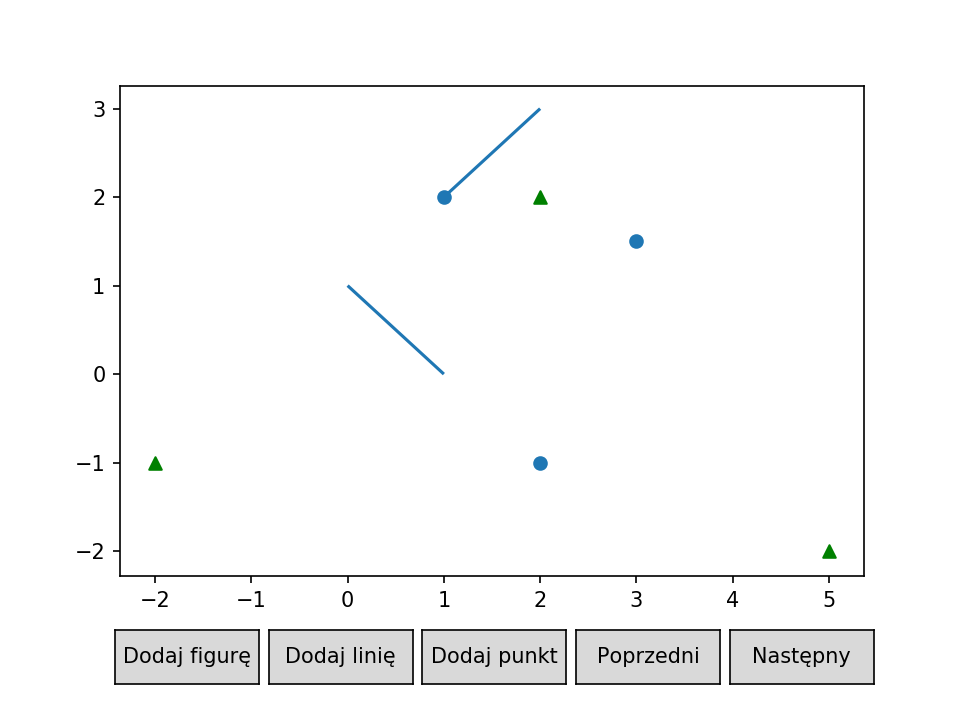

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


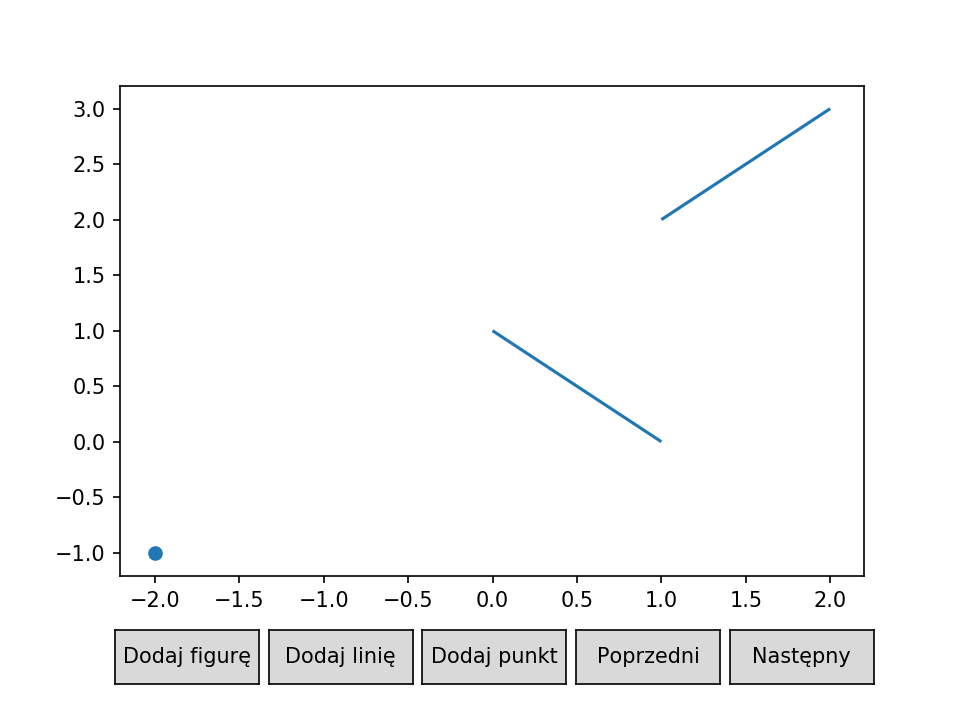

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

### Algorytm

In [5]:
# algorytm sutherlanda-hodgmana -> konieczne, aby punkty jako wejście były zgodnie ze wskazówkami zegara

def SutherlandHodgman(pointsOfSubjectPolygon, linesOfClippingPolygon):
    outputList = deepcopy(pointsOfSubjectPolygon)
    
    for clipEdge in linesOfClippingPolygon:
        inputList = deepcopy(outputList)
        outputList.clear()
        
        for index in range(len(inputList)):
            current_point = inputList[index]
            prev_point = inputList[(index + len(inputList) - 1) % len(inputList)]
            
            subjectEdge = [prev_point, current_point]
            if doLinesIntersect(subjectEdge, clipEdge):
                intersecting_point = findIntersection(clipEdge, subjectEdge)
              
            if isPointInClipEdge(current_point, clipEdge):
                if not isPointInClipEdge(prev_point, clipEdge):
                    outputList.append(intersecting_point)
                outputList.append(current_point)
            elif isPointInClipEdge(prev_point, clipEdge):
                outputList.append(intersecting_point)
    
    return outputList


def doLinesIntersect(section1, section2):
    vector1 = (section1[1][0]-section1[0][0],section1[1][1]-section1[0][1])
    vector2 = (section2[1][0]-section2[0][0],section2[1][1]-section2[0][1])
    
    matrix = [[vector1[0], vector1[1]],[vector2[0], vector2[1]]]
    det = np.linalg.det(matrix)
    
    return not (det==0)


def pointPosTowardsLine(point, line_points):
    epsilon = 10**(-6)
    base_matrix = [[line_points[0][0], line_points[0][1], 1.0],[line_points[1][0], line_points[1][1], 1.0],[point[0], point[1], 1.0]]
    determinant = np.linalg.det(base_matrix)
    
    if determinant > epsilon:
        return 1
    elif determinant < (-1)*epsilon:
        return -1
    else:
        return 0


def isPointInClipEdge(point, clipEdge):
    return pointPosTowardsLine(point, clipEdge) == -1


def findIntersection(section1, section2):
    #vector1 = (section1[1][0]-section1[0][0],section1[1][1]-section1[0][1])
    #vector2 = (section2[1][0]-section2[0][0],section2[1][1]-section2[0][1])

    #A1 = vector1[1]
    #B1 = -vector1[0]
    #C1 = -section1[0][0]*vector1[1]+section1[0][1]*vector1[0]
    #A2 = vector2[1]
    #B2 = -vector2[0]
    #C2 = -section2[0][0]*vector2[1]+section2[0][1]*vector2[0]
    
    #x = -(B2*C1-C2*B1)/(B2*A1-B1*A2)
    #y = -(A1*x+C1)/B1
    
    (x1, y1) = section1[0]
    (x2, y2) = section1[1]
    (x3, y3) = section2[0]
    (x4, y4) = section2[1]
    x = ((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/((x1-x2) * (y3-y4) - (y1-y2) * (x3-x4))
    y = ((x1*y2 - y1*x2) * (y3-y4)-(y1-y2) * (x3*y4 - y3*x4))/((x1-x2) * (y3-y4) - (y1-y2) * (x3-x4))
    
    return (x, y)

In [6]:
point1 = (3, 3)
point2 = (0, 1)
line = [(2, 2), (5, 5)]
point = (200,250)
line2 = [(150, 150), (150, 200)]

# print("point pos:", pointPosTowardsLine(point, line2))
# ----------------
figure1 = [(100,150), (200,250), (300,200)]
figure2 = [[(150,150), (150,200)], [(150,200), (200,200)], [(200,200),(200,150)],[(200,150),(150,150)]]
intersection = SutherlandHodgman(figure1, figure2)
print("Points of intersection: ", intersection)
print("Expected:", (150, 162), (150, 200), (200, 200), (200, 174))

Points of intersection:  [(200.0, 200.0), (200.0, 175.0), (150.0, 162.5), (150.0, 200.0)]
Expected: (150, 162) (150, 200) (200, 200) (200, 174)


In [96]:
%matplotlib notebook


def findIntersectionOf(figure1, figure2): # find intersection points and make figure out of them
    events = []
    
    lines = []
    lines.extend(figure1)
    lines.extend(figure2)
        
    intersections = modifiedSweepingAlgorithm(lines, figure1)
    
    return intersections


def findSumOf(figure1, figure2): # find intersecting points, make lines out of them and sum with existing nodes from both figures
    print(0)
    return 0


def modifiedSweepingAlgorithm(sections, figure1):
    events = []
    state = []
    intersectingPoints = []
    intersectingLines = []
    
    addPointsToEvents(events, sections)
    print("Events in beggining:", events)
    
    while not isHeapEmpty(events):
        event = heappop(events)
        
        updateBroomState(state, event, intersectingPoints, intersectingLines)
        updateEvents(events, state, event, intersectingPoints, intersectingLines, figure1)
        print("events after update:", events)
        print("state after update:", state)

    return intersectingPoints


def addPointsToEvents(events, figure):
    
    for line in figure:
        if line[0] not in events:
            heappush(events, line[0])
        if line[1] not in events:
            heappush(events, line[1])


def sortEventsByX(events):
    events.sort(key=lambda x: x[0])


def isHeapEmpty(heap):
    return (len(heap) == 0)   #lub heap.count(np.inf)==len(heap)


def updateBroomState(state, event, intersections, intersectingLines):
    broom_position = event[0]

    for section in sections: #update T
        if section[0][0] == broom_position:
            addToState(state, section)
        if section[1][0] == broom_position and section in state:
            state.remove(section)
    
    if event in intersections:
        index = intersections.index(event)
        [section1, section2] = intersectingLines[index]
        swapSectionsInState(state, section1, section2)


def swapSectionsInState(state, section1, section2):
    if section1 in state and section2 in state:
        index1 = state.index(section1)
        index2 = state.index(section2)
        state[index1], state[index2] = state[index2], state[index1]


def updateEvents(events, state, event, intersections, intersectingLines, figure1):
    broom_position = event[0]
    
    print("State: ", state)
    for index in range(len(state)-1): #update Q
        section1 = state[index]
        section2 = state[index+1]
        print("Before checking")
        print("Section1 in figure?:", (section1 in figure1))
        print("Section2 in figure?:", (section2 in figure1))
        print("Figure1: ", figure1)
        print("Section1: ", section1, "section2: ", section2)
        if (section1 in figure1 and section2 not in figure1) or (section1 not in figure1 and section2 in figure1):
            print("Lines are not in the same figure!!")
            print("Figure1: ", figure1)
            print("Section1: ", section1, "section2: ", section2)
            if doSectionsIntersect(state[index], state[index+1]):
                inter = findIntersection(state[index], state[index+1])
                if inter[0] >= broom_position and inter not in intersections:
                    heappush(events, inter)
                    intersections.append(inter)
                    intersectingLines.append([state[index], state[index+1]])

def addToState(state, section):
    index = 0
    
    while index < len(state) and state[index][0][1] < section[0][1]:
        index += 1
    
    if index == len(state):
        state.append(section)
    else:
        state.insert(index, section) # insert on index



def areFromTheSameFigure(section1, section2):
    
    return False


def doSectionsIntersect(section1, section2):
    
    if  pointPosTowardsLine(section1[0], section2) == pointPosTowardsLine(section1[1], section2):
        return False;
    
    if pointPosTowardsLine(section2[0], section1) == pointPosTowardsLine(section2[1], section1):
        return False;
    
    return True;


def pointPosTowardsLine(point, line_points):
    epsilon = 10**(-6)
    base_matrix = [[line_points[0][0], line_points[0][1], 1.0],[line_points[1][0], line_points[1][1], 1.0],[point[0], point[1], 1.0]]
    determinant = np.linalg.det(base_matrix)
        
    if determinant > epsilon:
        return 1
    elif determinant < (-1)*epsilon:
        return -1
    else:
        return 0


def findIntersection(section1, section2):
    vector1 = (section1[1][0]-section1[0][0],section1[1][1]-section1[0][1])
    vector2 = (section2[1][0]-section2[0][0],section2[1][1]-section2[0][1])
    
    A1 = vector1[1]
    B1 = -vector1[0]
    C1 = -section1[0][0]*vector1[1]+section1[0][1]*vector1[0]
    A2 = vector2[1]
    B2 = -vector2[0]
    C2 = -section2[0][0]*vector2[1]+section2[0][1]*vector2[0]
    
    x = -(B2*C1-C2*B1)/(B2*A1-B1*A2)
    y = -(A1*x+C1)/B1
    
    return (x, y)

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


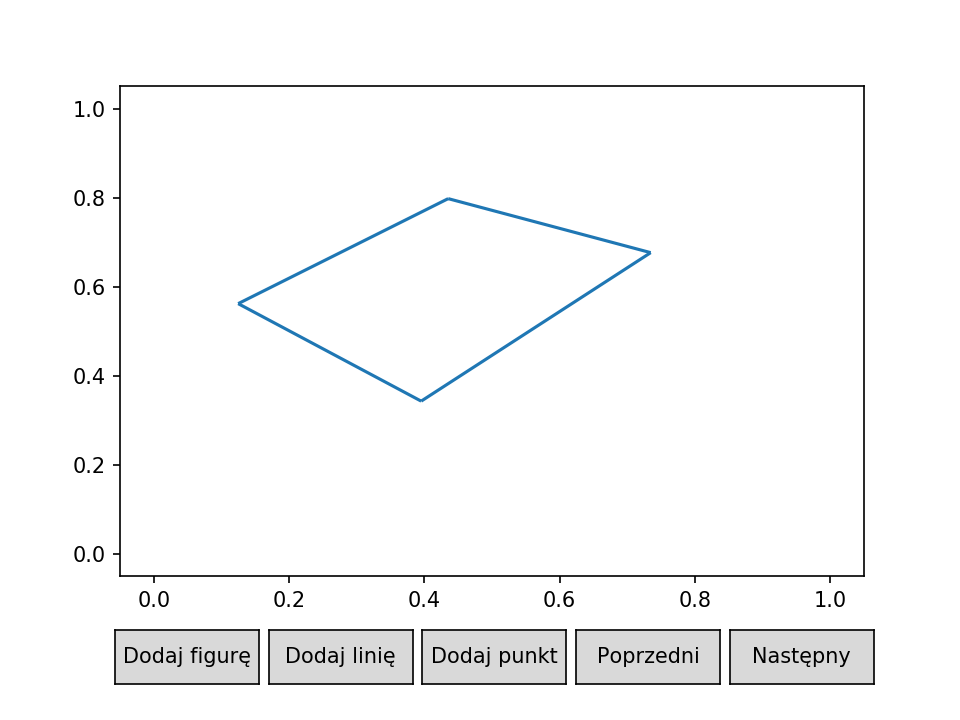

In [101]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


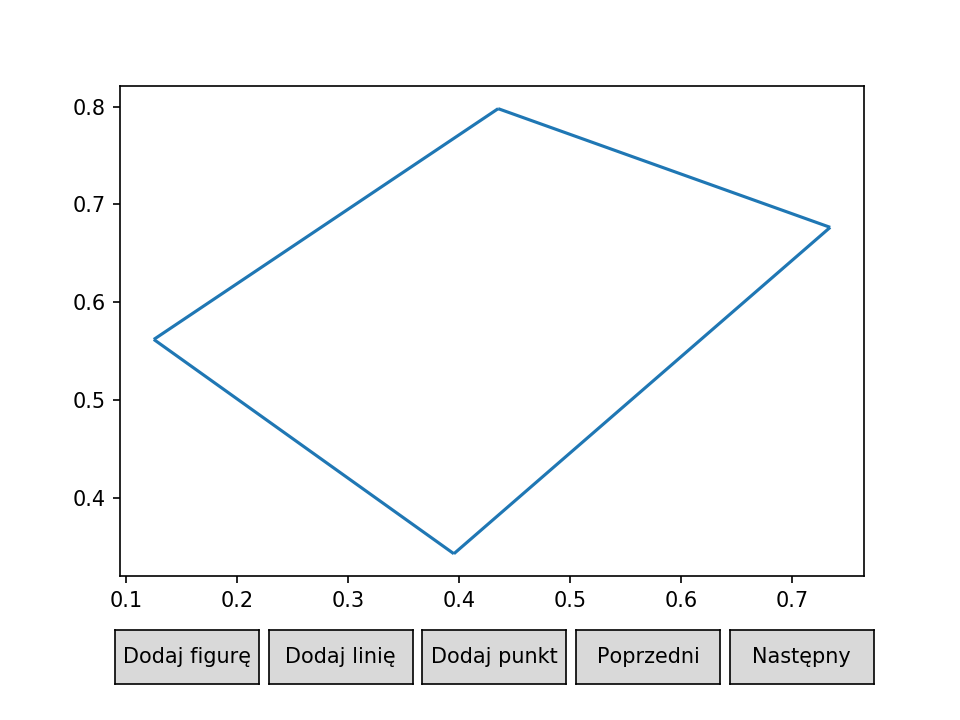

In [102]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Testy

In [103]:
# działa wyciąganie linii dodanych, nie działa znajdowanie przecięć
added_lines = plot1.get_added_elements().lines

lines = []

for line in added_lines:
    if len(line.lines) != 0:
        lines.append(line.lines)

print(lines[0])
#print(lines[1])
print("-----")

#intersection_of_figures = findIntersectionOf(lines[0], lines[1])
#print("Found points: ",intersection_of_figures)
#print("------")
# --------
figure1 = [[(0, 3), (5, 3)],[(5, 3), (3, 8)],[(3, 8), (0, 3)]]
figure2 = [[(1, 6), (4, 6)],[(4, 6), (3, 2)],[(3, 2), (2, 2)], [(2, 2), (1, 6)]]
lines = []
lines.extend(figure1)
lines.extend(figure2)

print(figure1)
print(figure2)
print(lines)
# --------------------
# sections = [[(-10, -10), (-20, -20)], [(2, 2), (4, 4)], [(2, 4), (4, 2)], [(1,1), (10,1)], [(5,1), (7,5)], [(-5, -5), (-1, -1)]]
# inters = modifiedSweepingAlgorithm(sections)
# print("Znalezione przecięcia: ", inters, "oczekiwane: ", [(3, 3), (5, 1)])
# ----------------------
intersections = findIntersectionOf(figure1, figure2)
print("Found points: ", intersections)

[[(0.39530407690232805, 0.34286217502519184), (0.12473956077329579, 0.5619185475742114)], [(0.12473956077329579, 0.5619185475742114), (0.4352234317410377, 0.7978254103193094)], [(0.4352234317410377, 0.7978254103193094), (0.7346185930313603, 0.6765018809075447)], [(0.7346185930313603, 0.6765018809075447), (0.39530407690232805, 0.34286217502519184)]]
-----
[[(0, 3), (5, 3)], [(5, 3), (3, 8)], [(3, 8), (0, 3)]]
[[(1, 6), (4, 6)], [(4, 6), (3, 2)], [(3, 2), (2, 2)], [(2, 2), (1, 6)]]
[[(0, 3), (5, 3)], [(5, 3), (3, 8)], [(3, 8), (0, 3)], [(1, 6), (4, 6)], [(4, 6), (3, 2)], [(3, 2), (2, 2)], [(2, 2), (1, 6)]]
Events in beggining: [(0, 3), (1, 6), (2, 2), (5, 3), (4, 6), (3, 8), (3, 2)]
State:  []
events after update: [(1, 6), (3, 2), (2, 2), (5, 3), (4, 6), (3, 8)]
state after update: []
State:  [[(1, 1), (10, 1)]]
events after update: [(2, 2), (3, 2), (3, 8), (5, 3), (4, 6)]
state after update: [[(1, 1), (10, 1)]]
State:  [[(1, 1), (10, 1)], [(2, 2), (4, 4)], [(2, 4), (4, 2)]]
Before check